<a href="https://colab.research.google.com/github/Mario-U-KY/DataScience/blob/main/2_5_Automatic_Differentiation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<h1> 2.5 Automatic Differentiation

미분은 딥러닝에서 중요한 스탭이나, 복잡한 모델에서 수동적으로 작업하는 것은 굉장히 어렵고 에러를 유발한다. 이에 딥러닝 프레임워크를 이용해서 자동적으로 미분값을 계산하는 방법을 사용한다. 이는 시스템으로 하여금 각 파라미터에 대한 편미분을 채워가며 computational graph를 추적하는 backpropagate를 의미한다

<h2> 2.5.1 A Simple Example

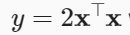

In [10]:
#위의 식을 x에 관하여 미분하기
import torch
x = torch.arange(4.0)
x

tensor([0., 1., 2., 3.])

계속 파라미터를 업데이트 할 것이기 때문에 항상 메모리를 할당해서는 안된다. 따라서 메모리를 보관할 storage가 필요.

In [11]:
x.requires_grad_(True) # tensor에서 이뤄진 모든 연산들을 추적한다.
#계산이 완료된 후 .backward()로 모든 변화도(gradient)를 자동 계산 가능하며
#이 텐서의 변화도는 .grad의 속성에 누적된다.
#기록 추적 중단을 위해서는 .detach()를 호출하면 멈출 수 있음
x.grad

In [12]:
y = 2*torch.dot(x,x)
y

tensor(28., grad_fn=<MulBackward0>)

X의 길이 4이므로, x와x의 내적이 수행되었고, y에 scalar output이 할당되었다. 이제 y의 gradient를 backpropagation으로 계산할 수 있음

In [13]:
y.backward()
x.grad #결과는 x=0,1,2,3에서 y의 미분값이 나온다.

tensor([ 0.,  4.,  8., 12.])

In [15]:
x.grad == 4*x

tensor([True, True, True, True])

In [16]:
# PyTorch accumulates the gradient in default, we need to clear the previous
# values
x.grad.zero_()
y = x.sum() #y = x1+x2+x3+... 가된다.
y.backward() #y 함수에 대한 x1,x2,x3,x4의 편미분값이 반환됨(모두 1)
x.grad

tensor([1., 1., 1., 1.])

<h2>2.5.2 Backward for Non-Scalar Variables

y가 스칼라 형태가 아닌경우, 벡터 y를 벡터 x로 미분한 값은 행렬의 형태로 나온다. 더 고차원의 y,x에 대해 그 미분 결과는 high-order tensor가 도출된다 

하지만, deep learning에서 벡터에 대한 backward를 진행할 때, 우리는 각 베치(batch)당 loss 함수의 미분값을 계산하려는 의도를 가지고 있다. 따라서, 우리는 미분행렬 자체를 구하는 것이 아니라, batch당, 개별적으로 구해진 편미분값의 합을 원한다.

In [18]:
# Invoking `backward` on a non-scalar requires passing in a `gradient` argument
# which specifies the gradient of the differentiated function w.r.t `self`.
# In our case, we simply want to sum the partial derivatives, so passing
# in a gradient of ones is appropriate
x.grad.zero_() #x의 gradient 초기화
y = x * x
# y.backward(torch.ones(len(x))) equivalent to the below
y.sum().backward() #grad값은 scalar 값에서만 구해질 수 있다. -> summation
y, x.grad

(tensor([0., 1., 4., 9.], grad_fn=<MulBackward0>), tensor([0., 2., 4., 6.]))

<h2> 2.5.3 Detaching Computation

우리는 computational graph 바깥에서 calculation을 기록하길 원하는 경우도 있다. y값이 x의 함수에 의해 계산되어졌고 연속적으로 z 가, y와 x에 의해 계산되어졌다고 가정하면, x에대한 z의 gradient 값을 구하기 위해 y를 상수로 여겨야 하며, y가 계산 된 이후 "X가 한 역할만" 구해내야 한다.

<br>
이에 y를 떼서 새로운 변수인 u(값은 같으나 정보를 기록하지 않는)를 대신 집어넣는 방법으로 gradient가 u를 거쳐서 x로 가지 않게끔 방지한다. z = u*x에 u를 상수로 여겨 z = x*x*x 대신에 사용한다

In [23]:
x.grad.zero_()#gradient 초기화
y = x*x
u = y.detach()
z = u*x
z.sum().backward()
x.grad == u #u가 상수로 쓰였으므로, ux를 x로 미분한 것은 u가 됨.

tensor([True, True, True, True])

y에대한 연산이 기록되었으므로, y=x*x에 대한 backpropagation을 진행할 수 있다.

In [24]:
x.grad.zero_()
y.sum().backward()
x.grad==2*x

tensor([True, True, True, True])

<h2> 2.5.4 Computing the Gradient of Python Control Flow

automatic differentiation을 사용해 얻는 이득은 파이썬의 복잡한 control flow(조건문, 반복문, 함수 등)을 거쳐서도 결과로 지정된 변수를 활용하면 gradient를 구할 수 있다는 것이다.

In [28]:
#아주 복잡하고 할당이 다양한 함수이나 a값에 따라 결국 k*a의 형태의 식을 반환
def f(a):
  b = a*2
  while b.norm() < 1000:
    b = b*2
  if b.sum() > 0:
    c = b
  else:
    c = 100*b
  return c


In [34]:
a = torch.randn(size=(), requires_grad=True)
d = f(a)
d.backward()
a.grad

tensor(1638400.)

In [35]:
a.grad == d/a

tensor(True)

즉 d의 a에대한 gradient값이, d/a의 값을 수행한 결과와 같다. 즉 f(x)를 거쳐서 나온 식이 상수배의 형태로 표시된다는 것을 증명할 수 있다.

<h2> 2.5.5 summary </h2>
정리하자면, python의 autograd를 사용해서 내가 편미분 하고싶은 파라미터(a)에 'requires_grad = True'로 트랙킹을 활성화 시키고, 최종 result에서 .backward()함수를 이용해 a.grad로 result의 변수 a에 대한 편미분 값을 확인할 수 있다. <br> 파라미터가 한개인 식 ex) y =  x*x의 경우 y의 미분값인 2x라는 도함수를 구하는 것과 같아지고 다변량의 경우에는 attach된 파라미터에 대한 partial derivative 값이 도출된다는 것을 유념하자.
<br>
파이썬의 이러한 툴은 메모리 누수를 방지하고, 복잡한 연산과정에서 생기는 오류를 방지하는 등 다양한 장점이 존재한다.